In [1]:
#IMPORTING SHIT
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin

import scipy
import scipy.signal
from scipy import signal
from scipy.io.wavfile import write
from scipy.linalg import hankel
from scipy.linalg import toeplitz
from scipy.signal import lfilter

from numpy.linalg import pinv

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3

import matplotlib.pyplot as plt
import numpy as np

import wave

import colorednoise as cn
#from matplotlib import pylab as plt

import sounddevice as sd
from scipy.io.wavfile import write

from tqdm import tqdm
import time

import pathlib
from util.util import load_data_json, to_db
from expr.analysis import load_analysis

import hr.pam as pam
import hr.process as pierre

%matplotlib widget

> ## Signal Synthesis

> Simple Noisless Signal with Two Sinusoids

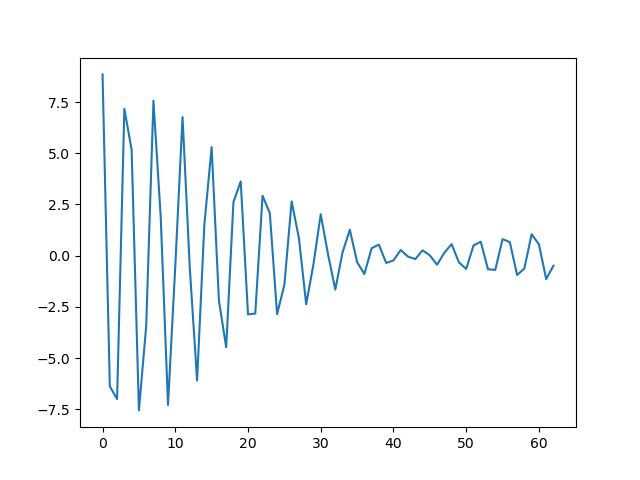

In [3]:
N_synth = 63

f0_synth = 1/4
f_synth = np.array([f0_synth, f0_synth+(1/N_synth)])

a_synth = np.array([1, 10])

delta_synth = np.array([0, -0.05])

phi_synth = np.array([1.5, 0.5])

# synthesised signal
x_synth = pam.synthesize(N_synth, delta_synth, f_synth, a_synth, phi_synth)

plt.plot(np.real(x_synth[0]))

#np.max(np.real(x_synth))

> Simple Noisless Signal with One Sinusoid and Vibrato Effect

In [4]:
N_vibr0 = 2**9-1

delta_vibr0 = np.array([0])

f_vibr0 = np.array([0.3])

a_vibr0 = np.array([2])

phi_vibr0 = np.array([0])

vibrato0 = pam.synthesize(N_vibr0, delta_vibr0, f_vibr0, a_vibr0, phi_vibr0, 0.02, 5, 0, 0)

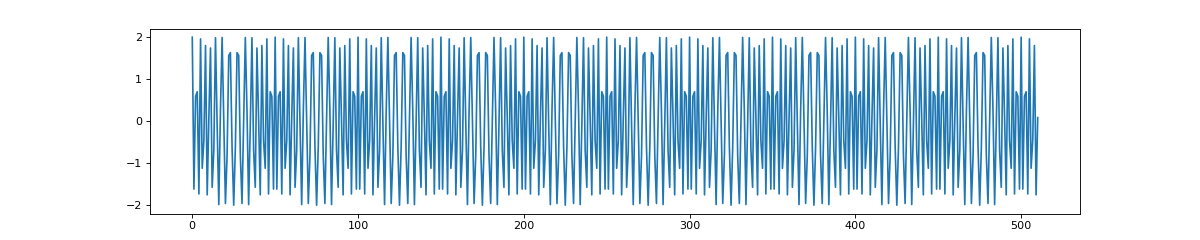

In [5]:
plt.figure(figsize=(15, 3), dpi=80)

plt.plot(np.real(vibrato0[0]))
plt.show()


In [6]:
fs_vibr0 = 1000

sd.play(np.real(vibrato0[0]), fs_vibr0)

print("The length of the signal is", N_vibr0/fs_vibr0, "seconds.")

t = np.linspace(0., N_vibr0/fs_vibr0, fs_vibr0)
amplitude = np.iinfo(np.int16).max
data  = amplitude*np.real(vibrato0[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("vibrato.wav", fs_vibr0, data.astype(np.int16))

The length of the signal is 0.511 seconds.


> Noisless Signal with Eight Sinusoids and vibrato Effect

In [7]:
N_vibr1 = 2**11-1

K_vibr1 = 8

f0_vibr1 = 0.06
f_vibr1 = f0_vibr1*np.arange(1,K_vibr1+1)

a_vibr1 = np.array([0.00807193, 0.09748246, 0.02404544, 0.04275309, 0.02482811,
       0.08778044, 0.00470351, 0.03118916])

delta_vibr1 = -0.0001*np.random.rand(K_vibr1)

phi_vibr1 = np.array([1.76348603, 1.20411769, 0.76158339, 1.35157899, 0.36247392,
       1.44086579, 1.73647764, 1.98131046])

vibrato1 = pam.synthesize(N_vibr1, delta_vibr1, f_vibr1, a_vibr1, phi_vibr1, 0.003, 10, 0, 0)

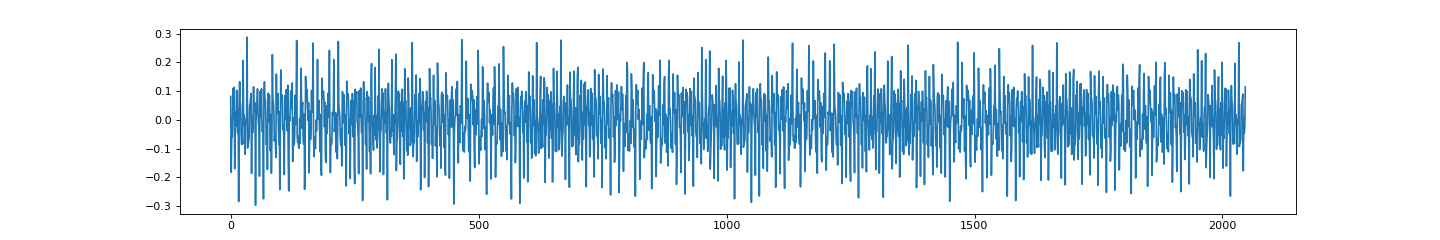

In [8]:
plt.figure(figsize=(18, 3), dpi=80)

plt.plot(np.real(vibrato1[0]))

plt.show()

In [9]:
fs_vibr1 = 1000

sd.play(np.real(vibrato1[0]), fs_vibr1)

print("The length of the signal is", N_vibr1/fs_vibr1, "seconds.")

t = np.linspace(0., N_vibr0/fs_vibr1, fs_vibr1)
amplitude = np.iinfo(np.int16).max
data  = amplitude*np.real(vibrato1[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("vibrato.wav", fs_vibr1, data.astype(np.int16))

The length of the signal is 2.047 seconds.


> Noisless Signal with Eight Sinusoids (Pink Noise and SNR = 39 dB)

SNR = 38.18562656072406 dB


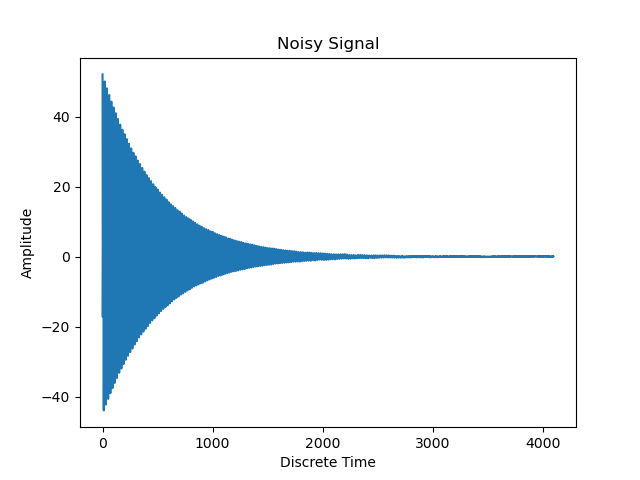

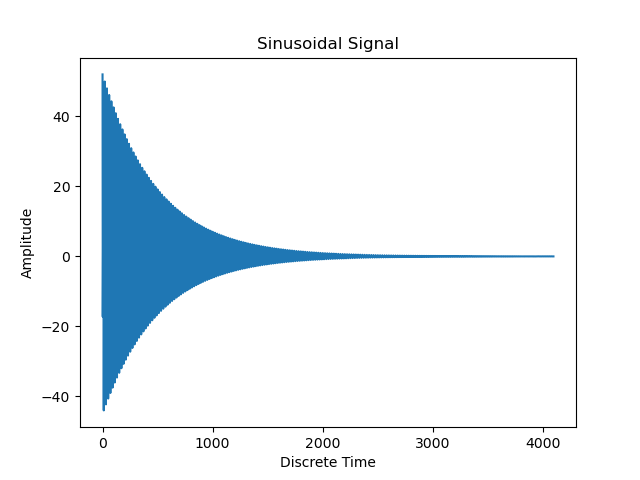

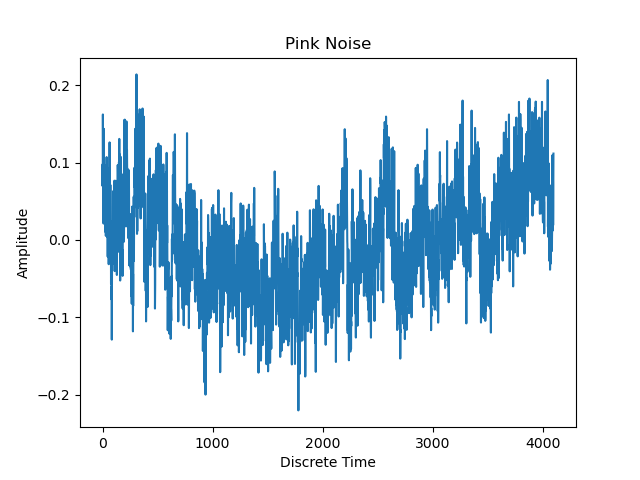

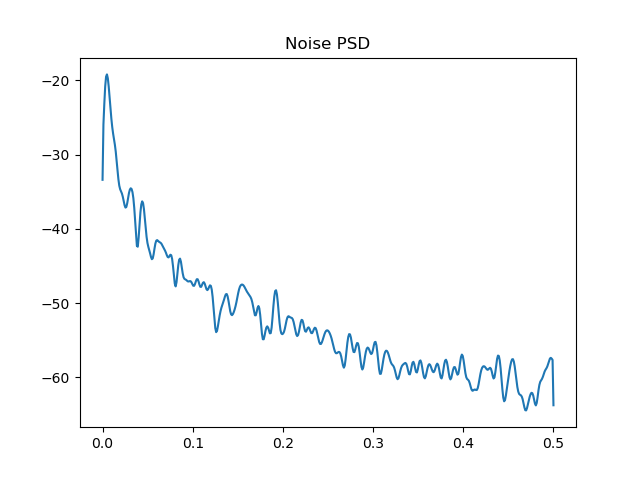

In [10]:
N_synth2 = 2**12-1

K_synth2 = 8

#f_synth2 = 0.48*np.random.rand(0,K_synth2) + 0.1*np.ones(K_synth2) 

#a_synth2 = 19*np.random.rand(0,K_synth2) + np.ones(K_synth2) 

f_synth2 = 0.05*np.arange(1,K_synth2+1)

a_synth2 = np.array([18, 15, 13, 11, 8, 5, 4, 3])

delta_synth2 = -0.002*np.ones([K_synth2])

phi_synth2 = np.array([0, 1.5, 0, 1, 0, 1.5, 0, 1])

# synthesised signal
x_synth2 = pam.synthesize(N_synth2, delta_synth2, f_synth2, a_synth2, phi_synth2, 0, 0, 2, 70)

print("SNR =", x_synth2[3], "dB")

plt.figure()
plt.plot(np.real(x_synth2[0]))
plt.title('Noisy Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(np.real(x_synth2[1]))
plt.title('Sinusoidal Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(x_synth2[2])
plt.title('Pink Noise')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
plt.show()


plt.figure()
plt.title("Noise PSD")
freq_synth2, PSD_noise_synth2 = signal.welch(x_synth2[2], nfft=1024)
plt.plot(freq_synth2, 20*np.log10(PSD_noise_synth2))
plt.show()


In [11]:
# play signal 
fs_synth2 = 1000

sd.play(np.real(x_synth2[0]), fs_synth2)

print("The length of the signal is", N_synth2/fs_synth2, "seconds.")

t = np.linspace(0., N_synth2/fs_synth2, fs_synth2)
amplitude = 0.01*np.iinfo(np.int16).max
data  = amplitude*np.real(x_synth2[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("noisy2.wav", fs_synth2, data.astype(np.int16))

The length of the signal is 4.095 seconds.


> ## Loading Experimental Data

C:\Users\royal\anaconda3\envs\env_pam_hr\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 512 is greater than input length  = 80, using nperseg = 80
  warnings.warn('nperseg = {0:d} is greater than input length '


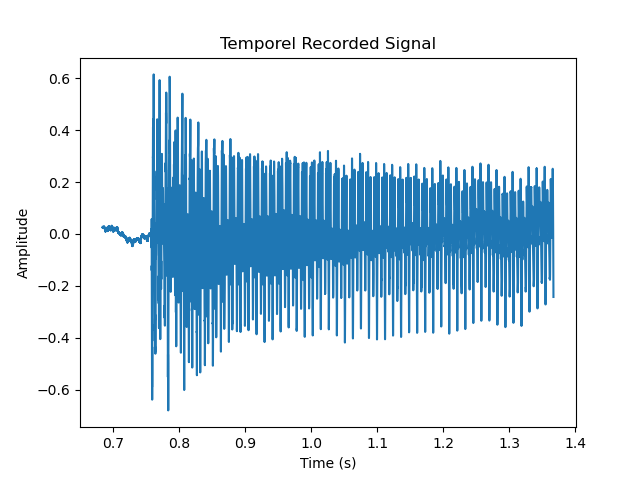

In [20]:
# Loading config from config files
conf_dir = pathlib.Path('./config/expr/')
data_dir = pathlib.Path('../data/expr/2022_01_27')
#
log_path = conf_dir / 'log_config.json'
conf_path = conf_dir / 'analysis_config.json'
data_path = data_dir / 'FirstStringGuitar_CopperWired005mm_5cmFromBridge_1.mat'

log = load_data_json(log_path)
conf = load_data_json(conf_path)
expr_data = load_analysis(data_path, conf)

# see expr/util.py for details on what's inside expr_data
mic = expr_data["temporal"]["mic"]["whole"][35000:70000]
times = expr_data["times"]["whole"][35000:70000]

plt.figure()
plt.title("Temporel Recorded Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(times, mic)
plt.show()

In [21]:
# play signal
fs_mic = int(1/(times[1]-times[0]))

sd.play(mic, fs_mic)

In [22]:
fft = np.fft.fft(band[35000:])
freqs = np.fft.fftfreq(mic[35000:].size)
plt.figure()
plt.plot(freqs*fs_mic, np.abs(fft))
plt.title('Periodogram')
plt.show()

NameError: name 'band' is not defined

> ## Signal Treatment

> Constructing the Filter Bank

10


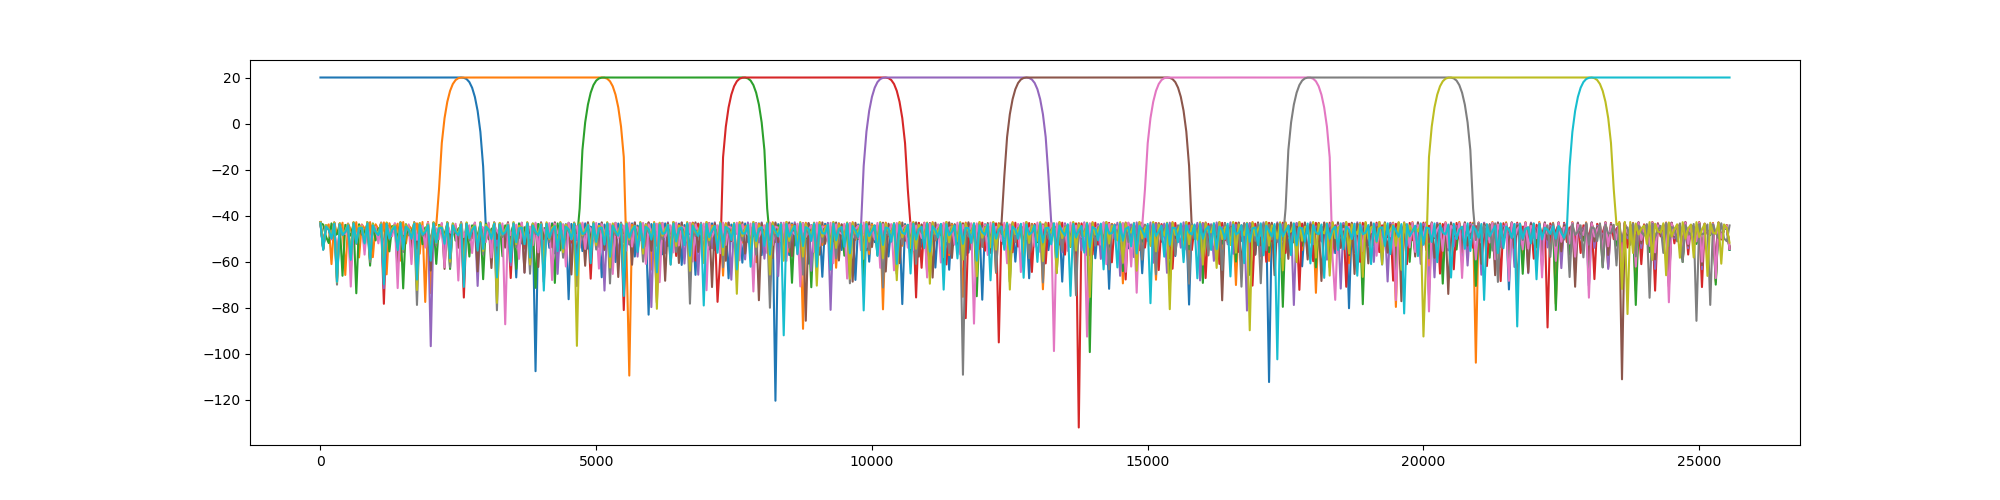

In [23]:
bank_coeffs = pam.filter_bank(10, fs_mic, 425, 425)

print(len(bank_coeffs))

plt.figure(figsize=[20,5])

for i in range(len(bank_coeffs)):
    
    freqs, amps = signal.freqz(bank_coeffs[i], [1])
    plt.plot(0.5*fs_mic*freqs/np.pi, 20*np.log10(np.abs(amps)))
    

plt.show()

> Filtering Signal with the Filter Bank and Decimation

In [24]:
num_bands = len(bank_coeffs)
mic_bands = []

for i in range(num_bands):
    filtered = signal.lfilter(bank_coeffs[i], [1], mic)
    decimated = pam.decimate(filtered, num_bands)
    mic_bands.append(decimated)
    

> PSD of Signal by Sub-bands

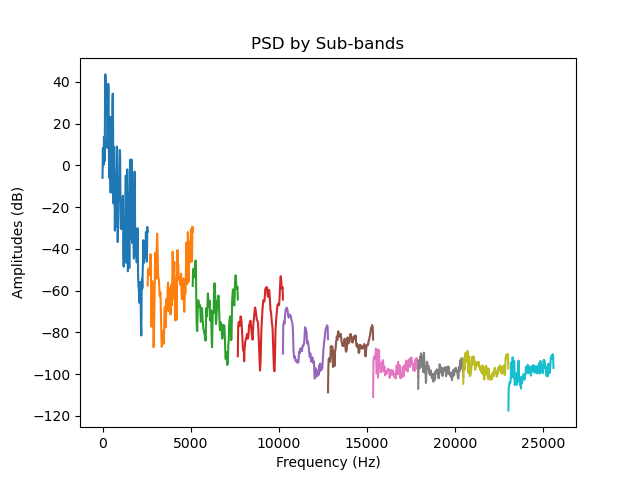

In [25]:
fs_bands = fs_mic//num_bands
plt.figure()
for i in range(num_bands):
    
    freqs, PSD = signal.welch(mic_bands[i])
    plt.plot(fs_bands*freqs+i*fs_bands/2, 20*np.log10(PSD))
    plt.title('PSD by Sub-bands')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitudes (dB)')

    #freqso, amps = signal.freqz(bank_coeffs[i], [1])
    #plt.plot(0.5*fs_mic*freqso/np.pi, 20*np.log10(np.abs(amps)))
plt.show()

#for i in range(num_bands):    
#    fft = np.fft.fft(mic_bands[i])
#    freqs = np.fft.fftfreq(mic_bands[i].size)
#    plt.figure()
#    plt.plot(freqs*fs_bands, np.abs(fft))
#    plt.show()

In [26]:
# play one sub-band
sd.play(mic_bands[0], fs_bands)

> #### Noise Whitening

> Testing with Synthetic Signal

[0.00278824 0.00175977 0.00093666 ... 0.00061663 0.00093666 0.00175977]
The minimum value for the smoothing order is 131.136


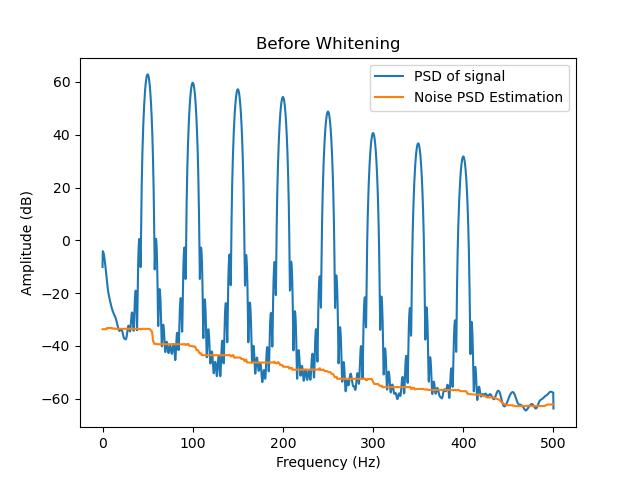

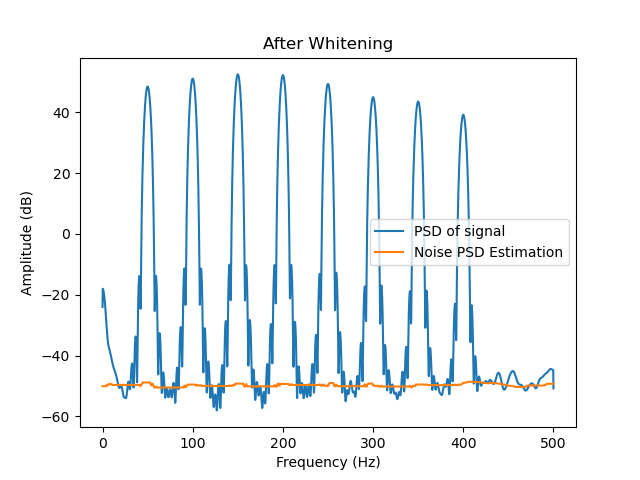

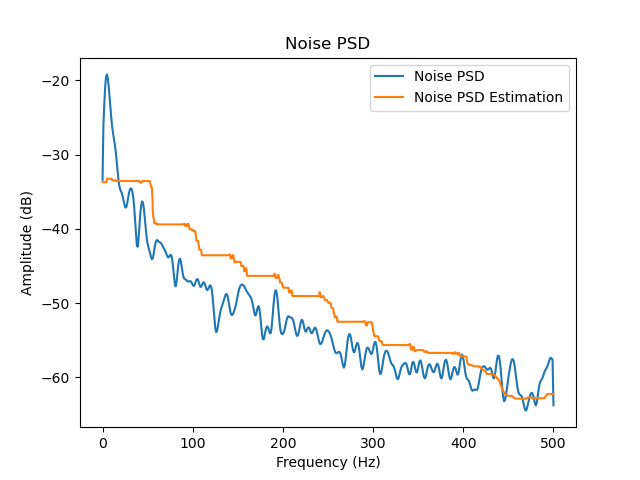

In [27]:
x_white2, freq2_norm, PSD_x2, PSD_noise2, PSD_x_white2, PSD_noise_white2 = pam.whiten(np.real(x_synth2[0]), 200, 15)

print('The minimum value for the smoothing order is', 4*0.016*len(freq2_norm))

freq2 = fs_synth2*freq2_norm

plt.figure()
plt.title('Before Whitening')
plt.plot(freq2, 20*np.log10((PSD_x2)), label = 'PSD of signal')
plt.plot(freq2, 20*np.log10((PSD_noise2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()

plt.figure()
plt.title('After Whitening')
plt.plot(freq2, 20*np.log10((PSD_x_white2)), label = 'PSD of signal')
plt.plot(freq2, 20*np.log10((PSD_noise_white2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()


plt.figure()
plt.title("Noise PSD")
plt.plot(fs_synth2*freq_synth2, 20*np.log10(PSD_noise_synth2), label = 'Noise PSD')
plt.plot(freq2, 20*np.log10((PSD_noise2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()

> Whitening the Experimental Signal (before filter bank)

[1.84576621e-05 1.69880135e-05 1.46934033e-05 ... 1.21650952e-05
 1.46934033e-05 1.69880135e-05]
The smoothing order must be at least 2097.216


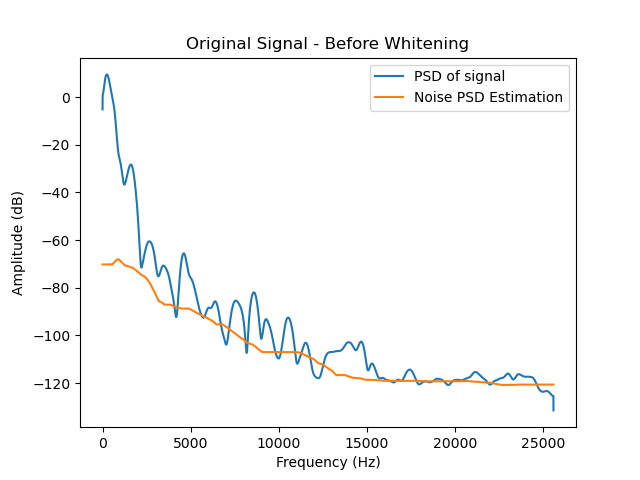

C:\Users\royal\AppData\Local\Temp\ipykernel_2072\55593754.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


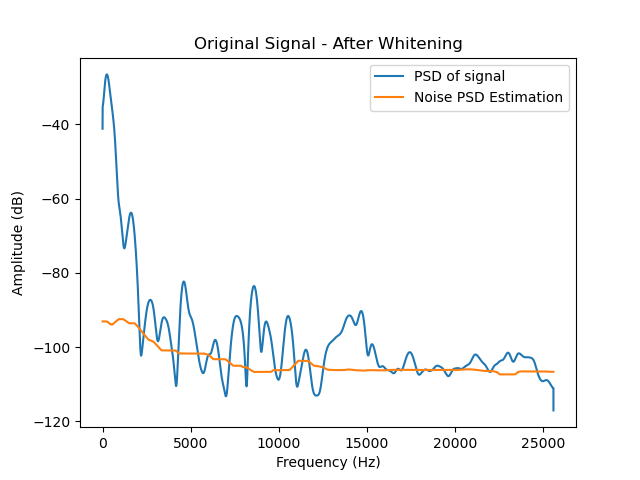

In [28]:
mic_white, freq_mic, PSD_mic, PSD_noise_mic, PSD_mic_white, PSD_noise_mic_white = pam.whiten(mic, 10000, 15)

print('The smoothing order must be at least', 4*0.016*len(freq_mic))

freq_mic *= fs_mic

plt.figure()
plt.title('Original Signal - Before Whitening')
plt.plot(freq_mic, 20*np.log10((PSD_mic)), label = 'PSD of signal')
plt.plot(freq_mic, 20*np.log10((PSD_noise_mic)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,500)
plt.legend()
plt.show()

plt.figure()
plt.title('Original Signal - After Whitening')
plt.plot(freq_mic, 20*np.log10((PSD_mic_white)), label = 'PSD of signal')
plt.plot(freq_mic, 20*np.log10((PSD_noise_mic_white)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,1000)
plt.legend()
plt.show()

> Whitening the First Band

[0.09649134 0.08725148 0.07019335 ... 0.05419433 0.07019335 0.08725148]
The smoothing order must be at least 131.136


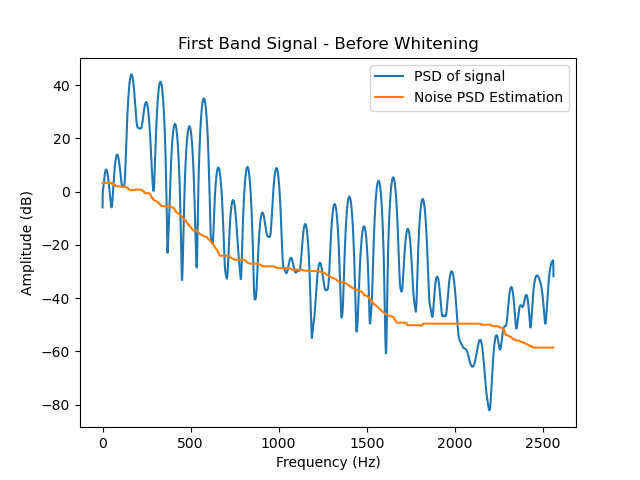

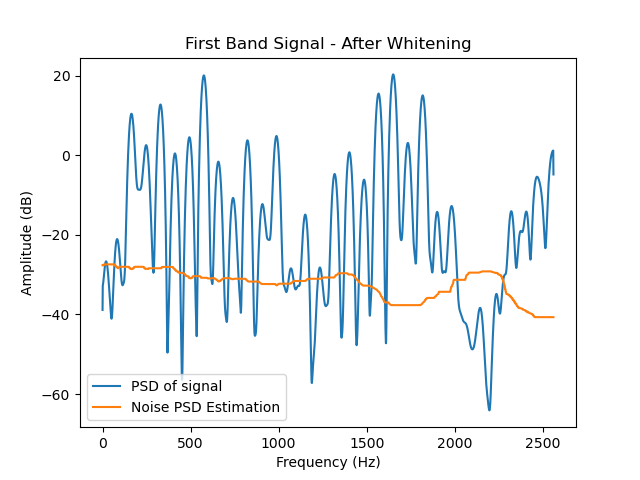

In [44]:
band0_white, freq_band0, PSD_band0, PSD_noise_band0, PSD_band0_white, PSD_noise_band0_white = pam.whiten(mic_bands[0], 1000, 15)

print('The smoothing order must be at least', 4*0.016*len(freq_band0))

freq_band0 *= fs_bands

plt.figure()
plt.title('First Band Signal - Before Whitening')
plt.plot(freq_band0, 20*np.log10((PSD_band0)), label = 'PSD of signal')
plt.plot(freq_band0, 20*np.log10((PSD_noise_band0)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,500)
plt.legend()
plt.show()

plt.figure()
plt.title('First Band Signal - After Whitening')
plt.plot(freq_band0, 20*np.log10((PSD_band0_white)), label = 'PSD of signal')
plt.plot(freq_band0, 20*np.log10((PSD_noise_band0_white)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,1000)
plt.legend()
plt.show()

> ## HR Analysis

> Testing EPRIT and LeastSquares

In [45]:
delta_an, f_an = pam.esprit(x_synth[0], 32, 2)

alpha_an, a_an, phi_an = pam.least_squares(x_synth[0], delta_an, f_an)

#EdB_an = Energy(x_synth, delta_an, a_an)

print(delta_an, f_an, alpha_an, a_an, phi_an)#, EdB_an)


[-5.00000000e-02 -1.11022302e-16] [0.26587302 0.25      ] [8.77582562+4.79425539j 0.0707372 +0.99749499j] [10.  1.] [0.5 1.5]


> Testing ESPRIT by Blocks (with a vibrato)

In [46]:
delta00, f00, alpha00, a00, phi00 = pam.esprit_blocks(vibrato0[0][:200], 0.035, 0.020, fs_vibr0, 32, 1)

print('- Damping factors:\n', delta00, '\n- Frequencies:\n', f00*fs_vibr0, '\n- Complex Amplitudes:\n', alpha00, '\n- Amplitudes:\n', a00, '\n- Intial Phases:\n', phi00 )

- Damping factors:
 [[-0.06462156]
 [-0.1059914 ]
 [-0.07731631]
 [-0.04093937]
 [-0.03264625]
 [-0.06462156]
 [-0.1059914 ]
 [-0.07731631]] 
- Frequencies:
 [[263.86192528]
 [295.01165819]
 [340.46558463]
 [251.49205179]
 [348.0143032 ]
 [263.86192528]
 [295.01165819]
 [340.46558463]] 
- Complex Amplitudes:
 [[ 0.48384274+0.86758021j]
 [-0.77708497+0.96585895j]
 [-0.39036651+0.70820166j]
 [ 0.70678423-1.15950977j]
 [ 0.6792423 +0.05645188j]
 [ 0.48384274+0.86758021j]
 [-0.77708497+0.96585895j]
 [-0.39036651+0.70820166j]] 
- Amplitudes:
 [[0.99337768]
 [1.23965502]
 [0.80866285]
 [1.35794214]
 [0.68158413]
 [0.99337768]
 [1.23965502]
 [0.80866285]] 
- Intial Phases:
 [[ 1.06206657]
 [ 2.24830748]
 [ 2.0745666 ]
 [-1.02338117]
 [ 0.08291951]
 [ 1.06206657]
 [ 2.24830748]
 [ 2.0745666 ]]


In [47]:
delta00, f00, alpha00, a00, phi00 = pam.esprit_blocks(vibrato1[0][:200], 0.035, 0.020, fs_vibr1, 32, 8)

print('- Damping factors:\n', delta00, '\n- Frequencies:\n', f00*fs_vibr1, '\n- Complex Amplitudes:\n', alpha00, '\n- Amplitudes:\n', a00, '\n- Intial Phases:\n', phi00 )

- Damping factors:
 [[-1.20146898e-03 -6.24602108e-02 -4.54321345e-03 -2.09628670e-02
  -7.38922474e-01 -1.25835379e+00 -1.40111543e+00 -8.30483503e-01]
 [ 1.33374992e-02 -2.70067833e-02 -1.87796106e-02 -2.46399558e-02
  -1.05206810e+00 -6.79572820e-01 -9.43951000e-01 -1.36489191e+00]
 [ 7.45610156e-03 -7.49570902e-02 -2.07370423e-02 -2.07088978e-02
  -1.11899225e+00 -3.10486302e+00 -1.17018183e+00 -9.39080535e-01]
 [-4.30775449e-03 -6.98718926e-02 -2.82851272e-02 -3.35562477e-02
  -1.15851846e+00 -1.86496413e+00 -1.32243756e+00 -2.38179706e+00]
 [-8.31321609e-03 -8.66458876e-02 -1.30053424e-02 -2.32969716e-02
  -7.93208428e-01 -1.79188723e+00 -7.39895857e-01 -1.01047262e+00]
 [-3.54182776e-02 -1.08008265e-02  3.59814204e-03 -5.46160622e-02
  -9.69972279e-01 -1.05236628e+00 -1.30573436e+00 -6.25876937e-01]
 [-1.86200560e-02 -1.04625100e-02  1.13728052e-02 -3.94038550e-02
  -1.61630396e+00 -8.57647738e-01 -1.17947274e+00 -1.51916020e+00]
 [ 1.41391580e-03 -1.86305803e-02 -1.25176895e-02

> HR Analysis for Experimental Signal

In [48]:
delta_mic, f_mic, alpha_mic, a_mic, phi_mic = pam.esprit_blocks(mic_white, 0.030, 0.020, fs_mic, 32, 30)

print( 'Frequencies:\n', f_mic*fs_mic, '\n\n- Damping factors:\n', delta_mic, '\n\n- Complex Amplitudes:\n', alpha_mic, '\n\n- Amplitudes:\n', a_mic, '\n\n- Intial Phases:\n', phi_mic )

Frequencies:
 [[    62.94325097    -62.94325097   1992.26789147  -1992.26789147
    6326.64665555  -6326.64665555   7955.23888058  -7955.23888058
    9471.89982059  -9471.89982059  11093.27242135 -11093.27242135
   12629.16414626 -12629.16414626  14197.07717302 -14197.07717302
   15725.41145506 -15725.41145506  17260.80724583 -17260.80724583
   18825.62084318 -18825.62084318  20425.04631682 -20425.04631682
   24671.08666492 -24671.08666492  23480.90228451 -23480.90228451
   21926.3405473  -21926.3405473 ]
 [     0.            451.36625028   -451.36625028   5442.2929282
   -5442.2929282    7112.72324552  -7112.72324552   8699.8794099
   -8699.8794099   10244.22076511 -10244.22076511  11727.63252517
  -11727.63252517  13390.86426566 -13390.86426566  14759.29895707
  -14759.29895707  16289.68780255 -16289.68780255  17847.93206732
  -17847.93206732  19264.94800206 -19264.94800206  20999.46835675
  -20999.46835675  25600.          23954.6761412  -23954.6761412
   22525.88689661 -22525.88689

In [49]:
band0_white_n = 64

band0_white_order_pmax = 64//2

band0_white_order = pierre.Ester.estimate_esm_ordre(band0_white, band0_white_n, band0_white_order_pmax)

band0_white_order

31

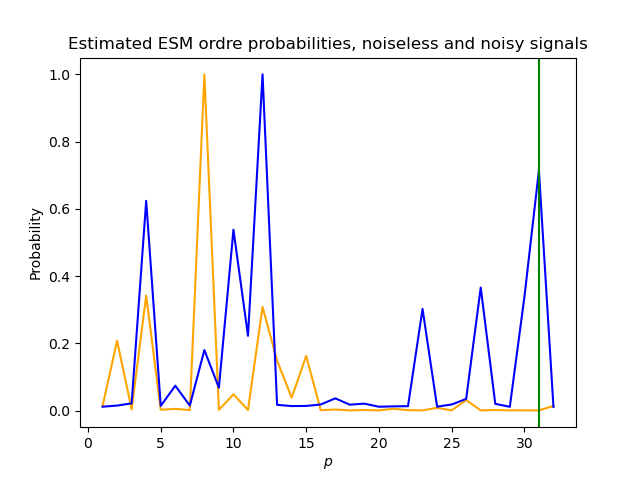

Ordre of the ESM model
Truth=31
 Noisy=15, Whitened=31


In [50]:
ps = np.arange(1,band0_white_order_pmax+1)
#j_sine = Ester.inverse_error_func(x_sine, n=n_est, p_max=p_max)
j_noise = pierre.Ester.inverse_error_func(mic_bands[0], n=band0_white_n, p_max=band0_white_order_pmax)
j_white = pierre.Ester.inverse_error_func(band0_white, n=band0_white_n, p_max=band0_white_order_pmax)

plt.figure()
plt.title('Estimated ESM ordre probabilities, noiseless and noisy signals')
plt.xlabel('$p$')
plt.ylabel('Probability')
#plt.plot(ps, j_sine/np.max(j_sine), c='cyan')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='b')
plt.axvline(band0_white_order, ymin=0, ymax=1, c='g')
plt.show()

#r_est_sine = Ester.estimate_esm_ordre(x_sine, n_est, p_max)
r_est_noise = pierre.Ester.estimate_esm_ordre(mic_bands[0], n=band0_white_n, p_max=band0_white_order_pmax)
r_est_white = pierre.Ester.estimate_esm_ordre(band0_white, n=band0_white_n, p_max=band0_white_order_pmax)
print('Ordre of the ESM model')
print(f'Truth={band0_white_order}')
print(f' Noisy={r_est_noise}, Whitened={r_est_white}')

In [52]:
delta_band0, freq_band0, alpha_band0, amp_band0, phi_band0 = pam.esprit_blocks(band0_white, 0.030, 0.020, fs_bands, band0_white_n, 2*band0_white_order)

print( 'Frequencies:\n', freq_band0*fs_bands) #, '\n\n- Damping factors:\n', delta_band0, '\n\n- Complex Amplitudes:\n', alpha_band0, '\n\n- Amplitudes:\n', amp_band0, '\n\n- Intial Phases:\n', phi_band0 )

Frequencies:
 [[   24.77583451   -24.77583451    60.61824472 ...  2459.13457529
  -2459.13457529  2560.        ]
 [    0.           501.40379046  -501.40379046 ... -2232.99751262
   2301.97062261 -2301.97062261]
 [   15.86348689   -15.86348689   150.13563254 ...  2523.59678476
  -2523.59678476  2560.        ]
 ...
 [ 2398.79926711 -2398.79926711  2560.         ...   -87.86040943
     34.84927971   -34.84927971]
 [    0.             0.            89.38324855 ... -2469.73190805
   2529.22459805 -2529.22459805]
 [ 2543.78872092 -2543.78872092  2453.4076173  ...   -84.2442033
      3.8109985     -3.8109985 ]]


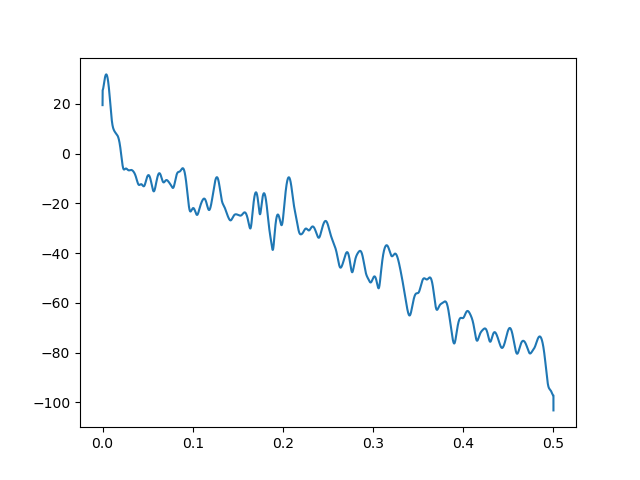

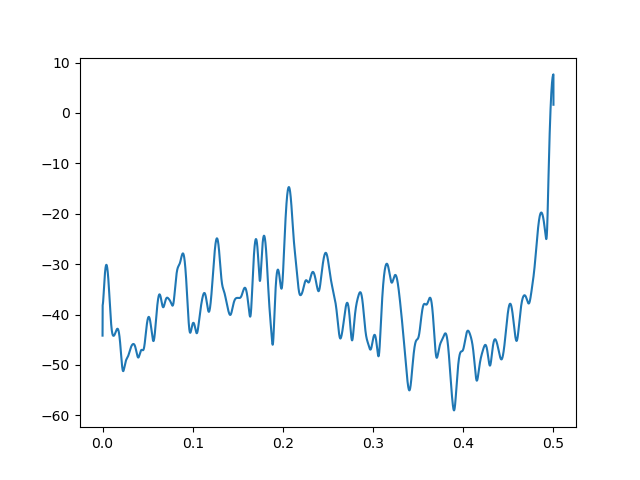

In [30]:
mic_pre, freq_pre, PSD_mic, PSD_mic_pre = pam.preemphasize(mic[35000:70000])

plt.figure()
plt.plot(freq_pre, 20*np.log10((PSD_mic)), label = 'PSD of signal')
plt.show()

plt.figure()
plt.plot(freq_pre, 20*np.log10((PSD_mic_pre)), label = 'PSD of signal')
plt.show()

In [5]:
def Adaptive(x : np.ndarray, n : int, r : float, fe : float, beta: float):
    # n : number of lines in W
    # r : estimation by ESTER of the order
    # # n>r
    # fe: sampling frequency
    #  0 < β < 1 is the forgetting factor

    # computation of W(0), Z(0)
    W0 = np.zeros(n, r)
    W0[:r, :] = np.identity(r)
    W0[r:, :] = 0
    Z0 = np.identity(r)
    
    # time step
    NbEch = len(x)
    t = (np.arange(0, NbEch)/fe)
    W = []
    W.append(W0)
    # W = np.zeros((1, t))
    # W[0] = W0
    

    Z = []
    Z.append(Z0)
    #Z = np.zeros((1, t))
    #Z[0] = Z0

    psi = []
    Phi = []    # the list of Φ(t) 
    eigenvalues = []

    #e = np.zeros((1, t))   #e(t) , not sure about the dimension
    phi = np.zeros((1, t)) #Θ(t) , not sure about the dimension
    #e_point = np.zeros((1, t)) #e'(t) , not sure about the dimension

    #matrix dimensions : y(t), h(t), g(t)
    #y = np.zeros((n, r))
    #h = np.zeros((r, r))
    #g = np.zeros((2, r))
  
    for i in t:  #from 0 to t-1
        # PAST main section
        y = W[i].conj().T @ x[i+1]
        h = Z[i] @ y
        g = h / (beta + y.conj().T @ h)

        # API main section
        e = x[i+1] - W[i]@y #e(t)
        phi = (np.identity(r) + np.linalg.norm(e)**2 @ g @g.conj().T)**(-1/2)
        Z[i+1] = 1/beta * phi.conj().T @ (np.identity(r) - g @ y.conj().T)@Z[i] @ np.linalg.inv(phi.conj().T)
        W[i+1] = (W[i] + e[i+1] @ g.conj().T) @ phi[i+1]

        # FAPI main section (constants)
        sigma_sqaure = np.linalg.norm(x[i+1])**2 - np.linalg.norm(y)**2
        tho = sigma_sqaure/ (1 + sigma_sqaure*np.linalg.norm(g)**2 + np.sqrt(1 + sigma_sqaure*np.linalg.norm(g)**2))
        nu = 1 - tho*np.linalg.norm(g)**2

        #vectors
        y_point = nu*y + tho*g
        h_point = Z[i].conj().T @ y_point
        big_sigma = tho/nu * (Z[i]@g - (h_point.conj().T @ g)@ g)
        Z[i+1] = 1/beta * (Z[i] - g @ h_point.conj().T + big_sigma @ g.conj().T) 
        e_point = nu*x[i+1] - W[i] @ y_point
        # update rules
        W[i+1] = W[i] + e_point[i+1] @ g.conj().T
        
        W.append(W[i+1])
        Z.append(Z[i+1])

        #Adaptive computation of the spectral matrix
        W_down = W[i][0:-1, :]
        W_up = W[i][1:, :]
        e_minus = W_down.conj().T @ e_point[1:, ]
        e_plus = W_up.conj().T @ e_point[0:-1, :]
        epoint_plus = e_plus + g @ (e_point[1:, ].conj().T @ e_point[0:-1, :])
        psi = W_down.conj().T @ W_up  #psi[i]

        psi.append(psi)
        psi = psi + e_minus @ g.conj().T  + g @ epoint_plus.conj().T #psi[i+1], update rules for Ψ(t)

        nu = W[i+1][-1, :]            #last row of W(t),
        phi_phi = psi.conj().T @ nu   # ϕ(t)
        big_phi = psi + 1/(1 - np.linalg.norm(nu)**2) * nu @ phi_phi.conj().T  # Φ(t)
        
        Phi.append(big_phi)
        
        D = scipy.linalg.eig(big_phi, left = False, right = False)    # D, eigenvalues of big_phi
        eigenvalues.append(D) 
        # eigenvalues tracking


        
        ### Adaptive computation of the spectral matrix
        return W, eigenvalues  # W is the list [W0 W1 W2 W3......], D is the list of eigenvalue

In [6]:
# Another code for filter bank and decimation (incomplete)

center_freqs = np.arange(100, 3000, 100) # à nous de définir selon le signal
def filter_bank0(sig : np.ndarray, center_freqs : np.ndarray, fe : float):
    #input
       #sig
       #center_freqs : centered frequencies in filter banks
       #fe : sampling frequency


    #filter banks
    #PSD_sig = plt.psd(sig)
    nb_bands = len(center_freqs)
    #crossover_gain = 10**(-3/20) # cross at -3db of gain for the adjacent bands

    #band edges, frequencies
    band_edges = np.zeros((nb_bands,2))
    #band_edges [:,0] = center_freqs -  
    #band_edges [:,1] = center_freqs +   

    h = [] #impulse response 
    sig_list = []  #Roy: I suggest that we use an numpy array
    for i in range(nb_bands):
       b, a = signal.butter(nb_bands, [band_edges[i,0],band_edges[i,1]], btype = 'bandpass',analog=False, fs=fe,output='SOS')
       #w, H = signal.sosfreqz(h[i], worN=2000,fs=fe)  #Compute the frequency response of a digital filter in SOS format     
       sig_list.append(lfilter(b, a, sig))
   
    return sig_list

KTM = K.T.M = 


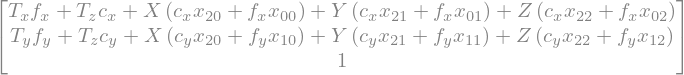

Vector of Unkowns xx.T = 


For equation HH.xx = mm, HH = 


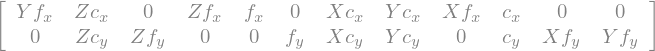

In [54]:
from IPython.display import display
import sympy as sy

sy.init_printing()  # LaTeX like pretty printing for IPython

# declaring symbolic variables:
x, y, X, Y, Z, fx, fy, cx, cy = sy.symbols("x y X Y Z f_x f_y c_x c_y", real=True)
x00, x01, x02, x10, x11 = sy.symbols("x00, x01, x02, x10, x11", real=True)
x12, x20, x21, x22 = sy.symbols("x12, x20, x21, x22", real=True)
Tx, Ty, Tz = sy.symbols(" T_x T_y T_z", real=True)

# Building matrices and vectors:
M = sy.Matrix([X, Y, Z, 1])
m = sy.Matrix([x, y, 1])
K = sy.Matrix([[fx,  0, cx, 0],
               [0,  fy, cy, 0],
               [0,   0,  0, 1]])
T = sy.Matrix([[x00, x01, x02, Tx],
               [x10, x11, x12, Ty],
               [x20, x21, x22, Tz],
               [0,     0,   0,  1]])

print("KTM = K.T.M = ")
KTM = sy.simplify(K*T*M)
display(KTM)

print("Vector of Unkowns xx.T = ")
xx = sy.Matrix(list(T.atoms(sy.Symbol)))
display(xx.T)
print("For equation HH.xx = mm, HH = ")
HH = KTM[:2, :].jacobian(xx)  # calculate the derivative for each unknown
display(HH)